In [163]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
import shutil

from tqdm.notebook import tqdm
from matplotlib import pyplot as plt

import IPython
from kerastuner import HyperModel, Hyperband

In [2]:
np.random.seed(2022)

### 데이터 생성하기

In [3]:
# =========================================
# 시계열 데이터 생성
# =========================================
n = 2349
p = 10
b_vec = np.arange(p,0,-1)/10
x_mat = np.random.normal(0,1,[n,p])
y_vec = np.dot(x_mat,b_vec) + np.random.normal(0,1,n)
y_vec = y_vec.cumsum()
y_vec = y_vec + abs(y_vec.min() )+ 100

In [4]:
# =========================================
# X ,Y 데이터 생성
# =========================================
columns = ["xvar_{}".format(x) for x in np.arange(0,10)]
xDF = pd.DataFrame(x_mat, columns = columns)
yDF = pd.DataFrame(y_vec,columns = ['Price'])
xyDF = pd.concat([xDF,yDF], axis = 1)

In [5]:
# =========================================
# Date 데이터 생성
# =========================================
xyDF['Date'] = pd.date_range(start = '2013-01-01', end = '2021-12-31', freq = '1B')

(array([15340., 15706., 16071., 16436., 16801., 17167., 17532., 17897.,
        18262., 18628., 18993.]),
 [Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, ''),
  Text(0, 0, '')])

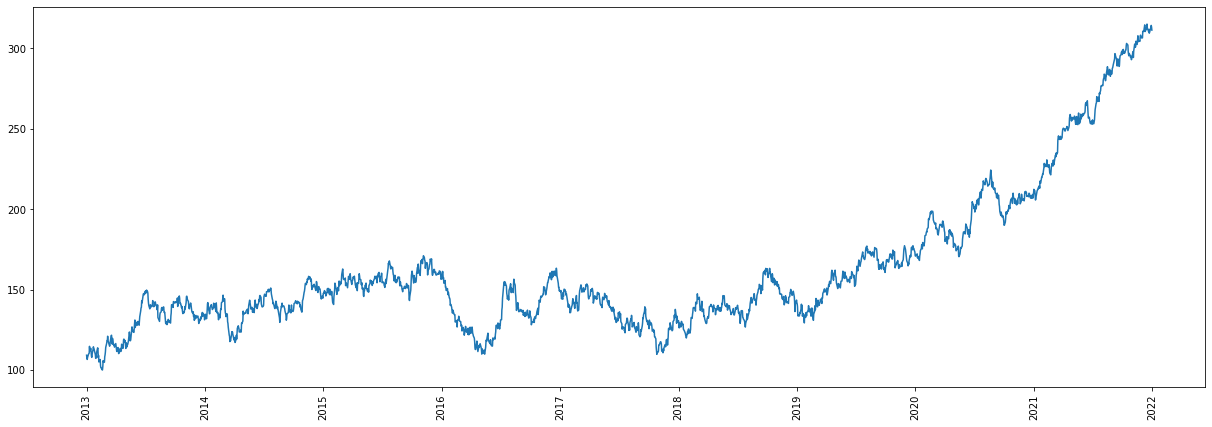

In [6]:
# =========================================
# Price 그래프 그려보기
# =========================================
plt.figure(figsize = [21,7])
plt.plot(xyDF['Date'], xyDF['Price'])
plt.xticks(rotation = 90)

### 데이터 전처리

In [7]:
# =========================================
# 65일 후 주가 예측 모델을 위한 데이터 전처리
# 학습      : 1040일(4년)
# Valdation : 65일(3개월)
# Test      : 65일 (3개월) 
# =========================================

model_code = 65
base_date = '20210101'

test_end_date = pd.date_range(base_date, periods=2, freq = "{}B".format(model_code))[1]
test_start_date = pd.date_range(test_end_date, periods = 2, freq = "-{}B".format(model_code))[1]
valid_end_date = pd.date_range(test_start_date, periods = 2, freq = "-1B".format(model_code))[1]
# valid_end_date = pd.date_range(test_start_date, periods = 2, freq = "-{}B".format(model_code))[1]
valid_start_date = pd.date_range(valid_end_date, periods = 2, freq = "-{}B".format(model_code))[1]
train_end_date = pd.date_range(valid_start_date, periods = 2, freq = "-{}B".format(1))[1]
train_start_date = pd.date_range(train_end_date, periods = 2, freq = "-{}B".format(1040))[1]


date_df = pd.DataFrame({"train_start" : train_start_date,
                        "train_end" : train_end_date,
                        "valid_start" : valid_start_date,
                        "valid_end" : valid_end_date,
                        "test_start" : test_start_date,
                        "test_end" : test_end_date}, index = [0])

date_df

,train_start,train_end,valid_start,valid_end,test_start,test_end
0,2016-10-05,2020-09-30,2020-10-01,2020-12-31,2021-01-01,2021-04-02


In [8]:
# =========================================
# Y 및 Y의 일자 생성
# =========================================
xyDF['Y'] = xyDF['Price'].shift(-1)
# xyDF['Y'] = xyDF['Price'].pct_change(65).shift(-65)
xyDF['Y_DATE'] = list(map(lambda xx : pd.date_range(xx, periods = 2, freq = '65B')[1],xyDF.Date))

In [9]:
# =========================================
# GRU X 데이터 생성을 위한 인덱스 Array 만들기
# EX)
#  : np.arange(0, 0 + nSteps * nInterval ,nInterval)
#  : np.arange(1, 1 + nSteps * nInterval ,nInterval)
#  : np.arange(2, 3 + nSteps * nInterval ,nInterval)
#  : np.arange(2209, 2209 + nSteps * nInterval ,nInterval)
#  : np.arange(x, x + nSteps * nInterval, nInterval)
# =========================================

nSteps = 15
nInterval = 10
dimBatch = len(xyDF) - nInterval*(nSteps - 1)
listidx = [np.arange(x, x + nSteps * nInterval, nInterval) for x in range(dimBatch)]

In [10]:
# =========================================
# GRU X, Y 데이터 생성
# =========================================

x_var = [s for s in xyDF.columns if 'xvar' in s]
#x_var = [s for s in xyDF.columns if 'Price' in s]
GRU_x = []
GRU_y = []
GRU_date = []

for i in range(dimBatch):
    
    ind = listidx[i]
    sub_xyDF = xyDF.iloc[ind,:]
    x = np.array(sub_xyDF[x_var])
    y = np.array(sub_xyDF.tail(1)['Y'])        # 해당 X의 가장 마지막 Y
    date = sub_xyDF.tail(1)[["Date","Y_DATE"]] # 해당 Y의 일자 -> Train, Valid, Test 구분을 위해 필요
    
    GRU_x.append(x)
    GRU_y.append(y)
    GRU_date.append(date)
    
    del(x,y,date,ind,sub_xyDF)
    
GRU_x = np.array(GRU_x)
GRU_y = np.array(GRU_y)
GRU_date = pd.concat(GRU_date)

In [11]:
print('X shape : ', GRU_x.shape)
print('y shape : ', GRU_y.shape)
print('date shape : ', GRU_date.shape)

X shape :  (2209, 15, 10)
y shape :  (2209, 1)
date shape :  (2209, 2)


In [12]:
# =========================================
# Train, Valid, Test 데이터로 분할
# =========================================

# 날짜 데이터 프레임으로 Train, Valid, Test Index 생성
Train_Index = (date_df.train_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.train_end[0])
Valid_Index = (date_df.valid_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.valid_end[0])
Test_Index = (date_df.test_start[0] <= GRU_date.Y_DATE)& (GRU_date.Y_DATE <= date_df.test_end[0])

# Train, Valid, Test 데이터 생성
Train_GRU_x = GRU_x[Train_Index,:,:]
Train_GRU_y = GRU_y[Train_Index,:]

Valid_GRU_x = GRU_x[Valid_Index,:,:]
Valid_GRU_y = GRU_y[Valid_Index,:]

Test_GRU_x = GRU_x[Test_Index,:,:]
Test_GRU_y = GRU_y[Test_Index,:]

In [13]:
# =========================================
# Min, Max Scale
# =========================================
# 각 Feature 별 Min Max 값 생성
Min_Max_DF = pd.DataFrame({})
for ind in range(Train_GRU_x.shape[2]):
    Max = Train_GRU_x[:,:,ind].max()
    Min = Train_GRU_x[:,:,ind].min()
    Min_Max_DF = pd.concat([Min_Max_DF, pd.DataFrame({"Feature_No": ind , "Max" : Max, "Min" : Min}, index = [0])])
    
Min_Max_DF.reset_index(drop = True, inplace = True)


# 각 Feature 별 Min Max Scale 진행
for ind in range(Train_GRU_x.shape[2]):
    # Train Min Max Scale
    Train_GRU_x[:,:,ind] = (Train_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])

    # Valid Min Max Scale
    Valid_GRU_x[:,:,ind] = (Valid_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])
    Valid_GRU_x[:,:,ind] = np.where(Valid_GRU_x[:,:,ind] >= 1 , 1, Valid_GRU_x[:,:,ind] ) # Train 에서 생성된 Max값으로 Scale 하기 때문에 
    Valid_GRU_x[:,:,ind] = np.where(Valid_GRU_x[:,:,ind] <= 0 , 0, Valid_GRU_x[:,:,ind] ) # Train 에서 생성된 Min값으로 Scale 하기 때문에

    # Test Min Max Scale
    Test_GRU_x[:,:,ind] = (Test_GRU_x[:,:,ind] - Min_Max_DF.iloc[ind,2])/(Min_Max_DF.iloc[ind,1] - Min_Max_DF.iloc[ind,2])
    Test_GRU_x[:,:,ind] = np.where(Test_GRU_x[:,:,ind] >= 1 , 1, Test_GRU_x[:,:,ind] ) # Train 에서 생성된 Max값으로 Scale 하기 때문에 
    Test_GRU_x[:,:,ind] = np.where(Test_GRU_x[:,:,ind] <= 0 , 0, Test_GRU_x[:,:,ind] ) # Train 에서 생성된 Min값으로 Scale 하기 때문에

In [14]:
# =========================================
# GRU HyperModel Class
# =========================================

class GRU_Model(HyperModel) :
    
    def __init__ (self, nSteps, nFeatures, nStacks, optimizer):
        self.nSteps        = nSteps
        self.nFeatures     = nFeatures
        self.nStacks       = nStacks
        self.optimizer     = optimizer
        

    def build(self, hp):
        
        # gru input layer
        layer_input = tf.keras.Input(shape = (self.nSteps, self.nFeatures), name = "input")
        
        # gru cell layer
        layer_state = tf.keras.layers.GRU(hp.Int('units', min_value = 32, max_value = 512, step = 32)
                                          ,return_state=True, name = 'gru_initial_state')(layer_input)[1]
        
        layer_gru   = tf.keras.layers.GRU(hp.Int('units', min_value = 32, max_value = 512, step = 32)
                                          ,return_sequences = True, name = 'gru_cell_0')(layer_input,initial_state = layer_state)
        
        if self.nStacks > 1 :
            for x in range(1 , self.nStacks) :
                layer_gru = tf.keras.layers.GRU(hp.Int('units', min_value = 32, max_value = 512, step = 32)
                                                ,return_sequences = True, name = 'gru_cell_{}'.format(x))(layer_gru)
        
        # gru output layer
        layer_output = tf.keras.layers.TimeDistributed(tf.keras.layers.Dense(units = 1, activation = 'linear',
                                                                            kernel_regularizer = tf.keras.regularizers.l2(l=hp.Float('regularizers', min_value = 0.1, max_value = 0.5, step = 0.1)),
                                                                            kernel_initializer = tf.keras.initializers.orthogonal(seed = 1234))
                                                                      , name = 'output')(layer_gru)  
        # gru model
        gru_model = tf.keras.Model(layer_input, layer_output)
            
        # custom loss
        def custom_loss(y_true, y_pred):
            mean = tf.reduce_mean(abs(y_true - y_pred)**2)
            std  = 1/(tf.math.reduce_std(y_pred) + 1/mean)
            return mean + std**2
              
            
        # Optimizer
        if self.optimizer == "Adam":
            optim = tf.keras.optimizers.Adam(learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]))
        if self.optimizer == "RMSprop":
            optim = tf.keras.optimizers.RMSprop(learning_rate = hp.Choice('learning_rate', values = [1e-2, 1e-3, 1e-4]))

        # Compile   
        gru_model.compile(optimizer = optim, loss = custom_loss)
        
        return gru_model

In [137]:
class GRU_TRAIN(object):
    
    def __init__ (self, Train_GRU_y, Train_GRU_x, Valid_GRU_y, Valid_GRU_x, nSteps, nFeatures, nStacks, optimizer, Patience , epochs, model_num):
        
        self.Train_GRU_y = Train_GRU_y
        self.Train_GRU_x = Train_GRU_x
        self.Valid_GRU_y = Valid_GRU_y
        self.Valid_GRU_x = Valid_GRU_x
        self.nSteps      = nSteps
        self.nFeatures   = nFeatures
        self.nStacks     = nStacks
        self.optimizer   = optimizer
        self.Patience    = Patience
        self.epochs      = epochs
        self.model_num   = model_num
        self.model       = self.gru_train()
                
    def gru_train(self):
        
        # 폴더 삭제
        shutil.rmtree('D:/worksapce/OUT/hyper_model_gru/'+'gru_{}'.format(self.model_num),ignore_errors=True)
        shutil.rmtree('D:/workspace/OUT/best_model_gru/best_model_gru_{}.h5'.format(self.model_num),ignore_errors=True)
        
        # Hyperband tuner setting
        tuner = Hyperband(GRU_Model(self.nSteps,self.nFeatures,self.nStacks,self.optimizer),
                             objective = 'val_loss', 
                             max_epochs = 5,
                             factor = 3,
                             directory = 'D:/worksapce/OUT/hyper_model_gru',
                             project_name = 'gru_{}'.format(self.model_num))

        # 
        class ClearTrainingOutput(tf.keras.callbacks.Callback):
            def on_train_end(*args, **kwargs):
                IPython.display.clear_output(wait = True)


        # tuner Serach
        tuner.search(self.Train_GRU_x, self.Train_GRU_y, epochs = self.epochs
                     , validation_data = (self.Valid_GRU_x, self.Valid_GRU_y)
                     , callbacks = [ClearTrainingOutput()]
                     , verbose = 0)

        # Get the optimal hyperparameters
        best_hps = tuner.get_best_hyperparameters(num_trials = 1)[0]
        
        # Build the model with the optimal hyperparameters and train it on the data
        gru_model = tuner.hypermodel.build(best_hps)
        
        # Early Stopping 
        """
        - restore_best_weights -
        Whether to restore model weights from the epoch with the best value of the monitored quantity.
        If False, the model weights obtained at the last step of training are used
        """
        EarlyStopping = tf.keras.callbacks.EarlyStopping(monitor = 'val_loss', mode = 'min', patience = self.Patience,
                                                         restore_best_weights=True, verbose = 1) 
        
        # reduce_lr
        reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(monitor='val_loss', factor=0.8, patience=10, verbose=0, mode='min', min_lr=1e-5)
        
        # 모델 저장
        ModelCheck = tf.keras.callbacks.ModelCheckpoint(filepath = 'D:/workspace/OUT/best_model_gru/best_model_gru_{}.h5'.format(self.model_num)
                                                        , monitor = 'val_loss'
                                                        , mode = 'min'
                                                        , save_best_only = True)
        # History
        history = tf.keras.callbacks.History()
        
        # 에폭 10까지 학습
        gru_model.fit(self.Train_GRU_x, self.Train_GRU_y, epochs = 10, validation_data=(self.Valid_GRU_x, self.Valid_GRU_y), verbose=0
                      , callbacks = [history])
        
        
        # 에폭 10부터 학습
        gru_model.fit(self.Train_GRU_x, self.Train_GRU_y
                      , initial_epoch = 10
                      , epochs = self.epochs
                      , validation_data=(self.Valid_GRU_x, self.Valid_GRU_y)
                      , callbacks = [EarlyStopping, reduce_lr, ModelCheck, history]
                      , verbose=0)
        
        return gru_model
        


In [169]:
# ============================================
# 모델 구조별 Fit
# ============================================

gru_mdl_list = {}
for i,j in tqdm(enumerate([[3,"RMSprop"],[3,"Adam"]]), desc = "1st"):
    mdl_num   = i
    nStacks   = j[0]
    optimizer = j[1]
    print("mdl_num :", mdl_num ,"nStacks :", nStacks, "optimizer :",optimizer)

    # get model
    gru_mdl = GRU_TRAIN(Train_GRU_y, Train_GRU_x, Valid_GRU_y, Valid_GRU_x, 15, 10, nStacks, optimizer, 30 , 100, mdl_num)

    # get bset epoch & valid loss
    best_epoch = np.argmin(gru_mdl.model.history.history['val_loss']) + 1
    vaild_loss = np.min(gru_mdl.model.history.history['val_loss'])


    gru_mdl_list['mdl_' + str(mdl_num)] = gru_mdl
    gru_mdl_list['mdl_{}_best_epoch'.format(mdl_num)] = best_epoch
    gru_mdl_list['mdl_{}_best_vaild_loss'.format(mdl_num)] = vaild_loss

    del(gru_mdl)

INFO:tensorflow:Oracle triggered exit


In [176]:
gru_mdl_list

{'mdl_0': <__main__.GRU_TRAIN at 0x243b17aad90>,
 'mdl_0_best_epoch': 18,
 'mdl_0_best_vaild_loss': 3351.626708984375,
 'mdl_1': <__main__.GRU_TRAIN at 0x243b41b4190>,
 'mdl_1_best_epoch': 100,
 'mdl_1_best_vaild_loss': 3574.677734375}

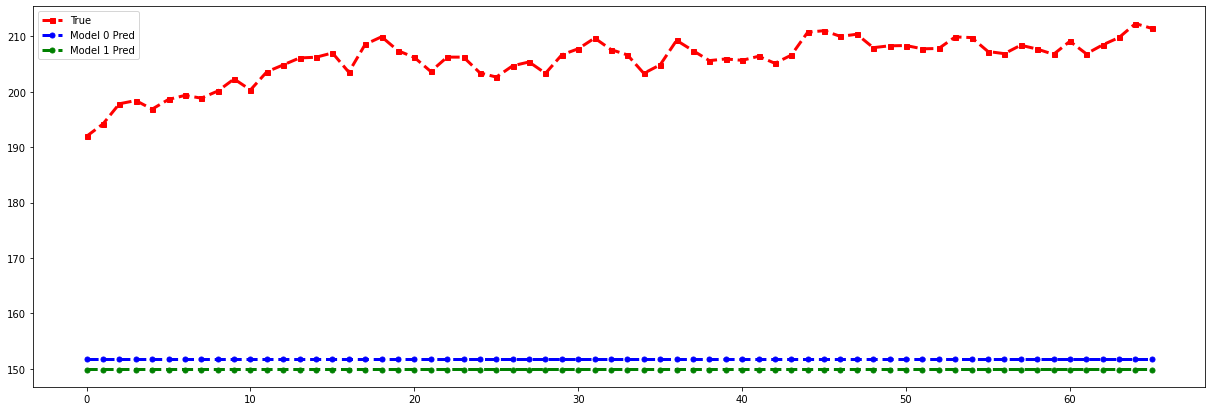

In [178]:
# Plot
plt.figure(figsize = (21,7))
plt.plot(Test_GRU_y, 'rs--', lw = 3, ms = 5, label = 'True')
plt.plot(gru_mdl_list['mdl_0'].model.predict(Test_GRU_x)[:,14,:], 'bo--', lw = 3, ms = 5, label = 'Model 0 Pred')
plt.plot(gru_mdl_list['mdl_1'].model.predict(Test_GRU_x)[:,14,:], 'go--', lw = 3, ms = 5, label = 'Model 1 Pred')
plt.legend()